In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# The Challenge

The dataset used here is synthetic. The original dataset dealt with identifying spam emails.
Submissions are evaluated on area under the ROC curve between the predicted **probability** and the observed target.

The challenge is thus to find a suitable classifier for this binary classification task. The features are all numeric. The dataset is realatively large. 

**THIS NOTEBOOK IS STILL A WORK-IN-PROGRESS, HOWEVER FEEL FREE TO EXPLORE, COMMENT AND UPVOTE**

## Imports

In [ ]:
import seaborn as sns 
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score # this is the metric used to score the competition
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, QuantileTransformer # scaling will be necessary for most models
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV # using a small validation + cv set may help
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.inspection import permutation_importance
from sklearn.decomposition import KernelPCA, PCA
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from skopt import BayesSearchCV # works similar to GridSearchCV but it doesn't try all param combinations, takes structure of search space into acc.

In [ ]:
RAND_STATE = 13

### FUNCTION TO RUN FOR TEST

As there will be some preprocessing steps to run on the test set, I will collect them in a function and later embed them in the pipeline.

In [ ]:
def prep_test_data(test_data):
    """Prepares Test Data for predictions, by applying all non-pipeline preproccessing steps.
        - Downcasting float and integer columns to save memory
        - Dropping 'id' feature
    
    Args:
        test_data(pd.DataFrame): DataFrame containing all columns of training data except id.
    Returns:
        test_data_prep(pd.DataFrame): DataFrame with features equal to training data. 
    """
    for col in test_data.columns:
        if test_data.loc[:,col].dtype == 'float64':
            test_data.loc[:,col] = pd.to_numeric(test_data.loc[:,col], downcast='float')   
        if test_data.loc[:,col].dtype == 'int64':
            test_data.loc[:,col] = pd.to_numeric(test_data.loc[:,col], downcast='integer')

    test_data_prep = test_data.drop('id', axis = 1)  
    return test_data_prep

## Read Data

In [ ]:
df_train = pd.read_csv('/kaggle/input/tabular-playground-series-nov-2021/train.csv')
df_test = pd.read_csv('/kaggle/input/tabular-playground-series-nov-2021/test.csv')

In [ ]:
df_train.shape

Downcast data due to size of dataset

In [ ]:
for col in df_train.columns:    
    if df_train.loc[:,col].dtype == 'float64':
        df_train.loc[:,col] = pd.to_numeric(df_train.loc[:,col], downcast='float')   
    if  df_train.loc[:,col].dtype == 'int64':
         df_train.loc[:,col] = pd.to_numeric(df_train.loc[:,col], downcast='integer')

In [ ]:
df_train.head()

Check for NAs. As dataset has many columns the first step is to check if any NAs exist in the whole dataset.

In [ ]:
df_train.isna().any().sum()

No NAs. A welcome suprise.

## Exploration

Let's view the target distribution. In case of it being uneven we might need to sample or pick certain models.

In [ ]:
fig, ax = plt.subplots(figsize = (7,7))
sns.countplot(x = df_train.loc[:,'target'], ax = ax)
sns.despine()

Looks pretty balanced, not much to do here.

There are a lot of features. To get a sense of the scale differences I will sample from the statistical descriptions.

In [ ]:
df_train.describe().T.sample(20)

Summary statistics differ quite a lot. The data needs to be scaled.

Visualizing the Distributions (takes very long)

In [ ]:
# fig, axes = plt.subplots(nrows = 10, ncols = 10, figsize = (20,20))
# axes = axes.flatten()

# df_plot = df_train.sample(frac = 0.33, random_state = RAND_STATE) #only use a third of the data to visualize
# for idx, axis in enumerate(axes):
#     sns.histplot(data = df_plot, x = f'f{idx}',
#                 ax = axis, hue = 'target', legend = False)
#     axis.set_ylabel('')    
#     axis.set_xlabel('')

If you run this cell you find that about half of the features have a bimodal distribution. The other half as a very skewed distribution that looks like a poisson or even exponential. I have attached the result as an image to spare some time.
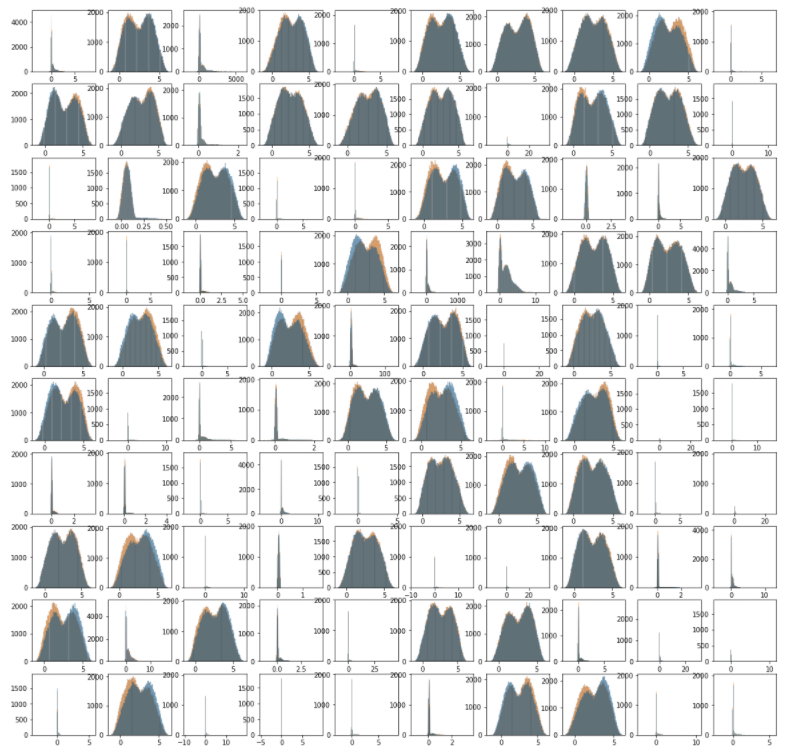

### Check correlations
As there are so many features we should first check if there are any at least moderately strong correlations (>.3). The first step is a visual inspection. If we would find any correlations here we could further investigate them.

In [ ]:
fig, ax = plt.subplots(figsize = (15,13))
sns.heatmap(df_train.corr(), ax = ax)

It doesn't look like there are any medium-strong or strong correlations. Which is good for avoiding multicolinearity and makes later feature selection e.g. through permutation feature importance easier. However, it also means that there are no simple linear relationships between target and features that our model could easily learn.

## Preprocessing

I am dropping the ID colum as it shouldn't provide value. Generally IDs can be tricky and might even lead to data leakage if they encode more than the index.

In [ ]:
df_train.drop('id', axis = 1, inplace = True) 

Another Preprocessing step will be the **Scaling** of features. This will be done in a pipeline and thus not for the whole training set before splitting.
As I wish to scale the data as well as transform the distributions to a more gaussian format (especially those that look to follow a poisson or even exponential distribution) I will use the QuantileTransformer. I will however at least for fast models test other Scalers (i.e. Standard,Robust,MinMax -Scaler) as well.

## Train-Val-Split, Feature-Target-Split

Although I am using cross validation during model selection and hyperparameter tuning I am splitting of another validation set in order to have a "sanity check" after selecting and tuning a model.

In [ ]:
features = df_train.drop('target', axis = 1)
target = df_train.loc[:,'target']

features_train, features_val, target_train,target_val = train_test_split(features, 
                                                                         target, 
                                                                         test_size = 0.1, 
                                                                         random_state = RAND_STATE)


In [ ]:
features_train.shape, features_val.shape

In [ ]:
target_train.shape, target_val.shape

## Baseline Model

Let's start with a simple Baseline model without preprocessing or using powerful models. This should only serve as a baseline, to show whether the problem can either be solved with a simple model, or to show if we went off the wrong path later on (e.g. by building a model that is much worse than the baseline. The baseline model also provides a sense of difficulty. We get a score that gives a sense of how high our metrics might be. Of course a powerful model can go way above the baseline. The last purpose of the baseline is a sanity check, if you try a lot of models but can barely get a score above the baseline something is wrong.

I often found that Decision Tree Classifiers are a good pick for baseline models as they don't require much preprocessing and are fairly quick and not too powerful.

In [ ]:
# base_dt = DecisionTreeClassifier()
# cross_val_score(base_dt, features_train, target_train, scoring = 'roc_auc', n_jobs = -1)

The result is a ROC-AUC of 0.55, which is not very high. However the score seems consistent troughtout the cv-folds, which is good. The process took relatively long, large models may not work well here.

# Modelling

The first step I am taking is to evaluate default/not-tuned models. I aim to tune the hyperparameters of the models which prove a) efficient and b) powerful.
I will also use feature selection after this first round of evaluations

There are a couple Models I aim to try out:

- Gaussian Naive Bayes
- Logistic Regression
- (Linear) Support Vector Machine
    - LinearSVC (doesn't provide probability predictions)
    - Stochastic Gradient Descent with hinge loss, which gives a Linear SVM
- ~Random Forest~ took very long, not very efficient.
- ~Ada Boost~ also took very long, removed for inefficiency.
- XGBoost



## Naive Bayes

As the dataset is quite large NB could provide a very economic choice. It's very fast, scales well and provides probabilities, which are needed for the submission.

In [ ]:
nb_clf = GaussianNB()
pipe_standard = Pipeline([('standard_scaler', StandardScaler()), ('nb_model', nb_clf)])
pipe_minmax = Pipeline([('minmax_scaler', MinMaxScaler()), ('nb_model', nb_clf)])
pipe_robust = Pipeline([('robust_scaler', RobustScaler()), ('nb_model', nb_clf)])
pipe_quantile = Pipeline([('quantile_scaler', QuantileTransformer()), ('nb_model', nb_clf)])
pipe_quantile_norm = Pipeline([('quantile_scaler', QuantileTransformer(output_distribution = 'normal')),
                          ('nb_model', nb_clf)])

In [ ]:
pipes = {'Standard': pipe_standard,
         'MinMax': pipe_minmax,
         'Robust': pipe_robust,
         'Quantile': pipe_quantile,
         'Quantile Normal Dist': pipe_quantile_norm}

for key,pipe in pipes.items():
    print(key)
    cv_scores = cross_val_score(pipe,features_train, target_train, 
                               scoring = 'roc_auc', n_jobs = -1)
    print(f"Mean ROC AUC: {np.mean(cv_scores)}")
    

Naive Bayes performs much better than the Decision Tree, it also works much faster.
NB + Quantile Transformer is surpringly strong. Will use it as a first submission and try to get better than that.

In [ ]:
pipe_quantile_norm.fit(features_train, target_train)
quant_nb_preds = pipe_quantile_norm.predict_proba(features_val)


In [ ]:
roc_auc_score(target_val, quant_nb_preds[:,1])

In [ ]:
# pipe_quantile_norm.fit(features_train, target_train)
# features_test = prep_test_data(df_test)
# quant_nb_preds_sub = pipe_quantile_norm.predict_proba(features_test)
# df_sub_quant_nb = pd.DataFrame({'id': df_test.loc[:,'id'], 'target':quant_nb_preds_sub[:,1]})
# df_sub_quant_nb
#df_sub_quant_nb.to_csv('submission.csv', index = None)

## Logistic Regression

In [ ]:
log_clf = LogisticRegression(n_jobs = -1)
quant_norm = QuantileTransformer(output_distribution = 'normal')
pipe_robust_log = Pipeline([('robust_scaler', RobustScaler()), ('LogReg',log_clf)])
pipe_log = Pipeline([('Quantile Transformer', quant_norm),('LogReg',log_clf)])

## Random Forest 

In [ ]:
# rf_clf = RandomForestClassifier(n_jobs = -1, random_state = RAND_STATE)
# pipe_rf = Pipeline([('Quantile Transformer', quant_norm),('RandomForest',rf_clf)])

## AdaBoost

In [ ]:
# ada_clf = AdaBoostClassifier(random_state = RAND_STATE)
# pipe_ada = Pipeline([('Quantile Transformer', quant_norm),('AdaBoost',ada_clf)])

## Linear SVC
I am using SGB with hinge loss which results in a linear SVM, and LinearSVC  neither however provide a `.predict_proba()` method and SVC is too slow, which makes them unsuited for submissions unfortunately. You can use them for submissions but scoring is suppossed to happen on probabilities not binary values.

In [ ]:
svc_clf = LinearSVC(dual = False)
pipe_robust_svc = Pipeline([('robust_scaler', RobustScaler()), ('LinearSVC',svc_clf)])
pipe_svc = Pipeline([('Quantile Transformer', quant_norm),('LinearSVC',svc_clf)])

In [ ]:
svcsgd_clf = SGDClassifier(loss = 'hinge', n_jobs = -1)
pipe_robust_svcsgd = Pipeline([('robust_scaler', RobustScaler()), ('LinearSGDSVC',svcsgd_clf)])
pipe_svcsgd = Pipeline([('Quantile Transformer', quant_norm),('LinearSGDSVC',svcsgd_clf)])

## XGB

AS other complex models took a very long time to run I will only train one XGBClassifier.
I am using parameters here which I found in the [Notebook of WOO SEUNG HAN ](https://www.kaggle.com/hadeux/kor-eng-simple-xgboost-model/notebook). Please visit this notebook and upvote it if you found it as useful as I did.

**The next cell will take hours to run, so please be cautious if you want to use it.**

In [ ]:
# XGB_clf = XGBClassifier(max_depth = 5,
#                                  learning_rate = 0.007,
#                                  n_estimators = 7000,
#                                  objective = 'binary:logistic',
#                                  booster = 'gbtree',
#                                  gamma = 1.5,
#                                  max_delta_step = 3,
#                                  min_child_weight = 10,
#                                  subsample = 0.6,
#                                  colsample_bytree = 0.8,
#                                  n_jobs = -1
#                                  )

# quant_scaler = QuantileTransformer()
# features_train_xgb = pd.DataFrame(quant_scaler.fit_transform(features_train))
# features_val_xgb = pd.DataFrame(quant_scaler.transform(features_val))

# xgb = XGB_clf.fit(features_train_xgb.values,
#                        target_train.values.ravel(),
#                        eval_set = [(features_train_xgb.values, target_train), (features_val_xgb.values, target_val)], 
#                        eval_metric = 'auc',
#                        early_stopping_rounds = 25,
#                        verbose = True)

Performance was pretty good on the validation set. I will submit the predictions manually to not run this in the notebook again. Submission score was a roc-auc of 0.740. The model may have overfit, it did not perform better than simpler models.

Still, XGB proves to be a good non-NN choice, but the model takes pretty long to train (hours) so it might not be efficient either way, unless you have powerful hardware or retraining is not an issue because it happens rarely. If you want or have to retrain often another model might be a better choice. 

As stated before I will not pursue any hyperparameter-tuning due to the time-constraints.

In [ ]:
# features_test = prep_test_data(df_test)
# features_test = pd.DataFrame(quant_scaler.transform(features_test))
# quant_xgb_preds_sub = xgb.predict_proba(features_test)
# df_sub_quant_xgb = pd.DataFrame({'id': df_test.loc[:,'id'], 'target':quant_xgb_preds_sub[:,1]})
# print(df_sub_quant_xgb.head())
# df_sub_quant_xgb.to_csv('df_sub_quant_xgb.csv', index = None)

In [ ]:
#df_sub_quant_xgb.to_csv('submission_quant_xgb.csv', index = None)

### Compare Baseline Models

In [ ]:
pipes = {'Quant LogReg': pipe_log,
         'Robust LogReg': pipe_robust_log,
         #'RandomForest':pipe_rf,
        #'AdaBoost':pipe_ada,
         'Quant LinearSVC':pipe_svc,
         'Robust LinearSVC': pipe_robust_svc,
        'Quant LinearSGDSVC': pipe_svcsgd,
        'Robust LinearSGDSVC': pipe_robust_svcsgd,}

for key,pipe in pipes.items():
    print(key)
    cv_scores = cross_val_score(pipe,features_train, target_train, 
                               scoring = 'roc_auc', n_jobs = -1)
    print(f"Mean ROC AUC: {np.mean(cv_scores)}")

Random Forest takes a very long time so does AdaBoost. Will not continue with them. Long training times makes Hyperparametertuning very inefficient.

Robust Scaling + Logistic Regression worked best so far.
I will go ahead and try to optimize this model but also work on the feature selection.

In [ ]:
pipe_robust_log.fit(features_train, target_train)
features_test = prep_test_data(df_test)
quant_log_preds_sub = pipe_robust_log.predict_proba(features_test)
df_sub_quant_log = pd.DataFrame({'id': df_test.loc[:,'id'], 'target':quant_log_preds_sub[:,1]})
df_sub_quant_log.to_csv('submission_robust_log.csv', index = None)

Given how fast the LogReg is, and that it performs better with Robust Scaling than with Quantiles I may try all scalers on it to see if robust scaling is the best option.

In [ ]:
# pipe_robust_svc.fit(features_train, target_train)
# features_test = prep_test_data(df_test)
# quant_svc_preds_sub = pipe_robust_svc.predict(features_test)
# df_sub_quant_svc = pd.DataFrame({'id': df_test.loc[:,'id'], 'target':quant_svc_preds_sub})
# df_sub_quant_svc.to_csv('submission_robust_svc.csv', index = None)

## Feature Selection

Moving on with all 100 Features does not seem efficient. Selecting fewer features may also boost performance.

I will try two strategies
1. Permutation Feature Importance (model specific)
2. SelectKBest (model agnostic)


### Permutation Feature Importance

Permutation Feature Importance is a technique where a model is fit to the data and one feature is "scrambled", meaning it will be shuffled to break any relations between feature and target. The score of the model on this changed dataset is evaluated against the score for the intact dataset. If the score is significantly lower the feature is deemed important, as it contributes to a higher score when intact. This process is done for all features. The technique is always specific to a certain model and it's use of features. Result can not be extrapolated to other models.

In [ ]:
perm_feat_imp_logreg = permutation_importance(pipe_robust_log, 
                                               features, target, 
                                               scoring = 'roc_auc',
                                               n_repeats = 3,
                                               n_jobs = -1, 
                                               random_state = RAND_STATE)

In [ ]:
perm_feat_imp_logreg_series = pd.Series(perm_feat_imp_logreg.get('importances_mean'),index = features.columns,)
perm_feat_imp_logreg_series = perm_feat_imp_logreg_series.sort_values(ascending = False)

fig,ax = plt.subplots(figsize = (15,20))
sns.barplot(y = perm_feat_imp_logreg_series.index,
            x = perm_feat_imp_logreg_series.values,
            ax = ax)
sns.despine()

In [ ]:
features_reduced = features_train.loc[:,perm_feat_imp_logreg_series[:40].index]

In [ ]:
cv_scores = cross_val_score(pipe_robust_log,features_reduced, target_train, 
                               scoring = 'roc_auc', n_jobs = -1)
print(f"Mean ROC AUC: {np.mean(cv_scores)}")

Altough we are working with only important features the use of less features provides no improvement in the score. It does however speed up the process.

In [ ]:
# features_reduced = features.loc[:,perm_feat_imp_logreg_series[:30].index]
# pipe_robust_log.fit(features_reduced, target)
# features_test = prep_test_data(df_test).loc[:,perm_feat_imp_logreg_series[:30].index]
# quant_log_preds_sub = pipe_robust_log.predict_proba(features_test)
# df_sub_quant_log = pd.DataFrame({'id': df_test.loc[:,'id'], 'target':quant_log_preds_sub[:,1]})
# df_sub_quant_log.to_csv('submission_robust_log.csv', index = None)

In [ ]:
#df_sub_quant_log.to_csv('submission.csv', index = None)

## SelectKBest

SelectKBest selects features according to the k highest scores given by a scoring function. The default is the ANOVA F-value between label/feature, there are many other scoring functions available such as chi² (chi2 only takes positive values which rules it out here).

In [ ]:
selector_f = SelectKBest(score_func = f_classif, k = 40)
selector_f.fit(features_train, target_train)

In [ ]:
col_index = selector_f.get_support(indices=True)
col_names = features_train.iloc[:,col_index].columns
pd.Series(selector_f.scores_[:40], index = col_names)

Those features should be our best features with respect to their relationship with the target. Let's try the above used algorithms again on only these.

In [ ]:
features_train_kbest = features_train.iloc[:,col_index]

pipes = {'Quantile Uni NB': pipe_quantile,
         'Quantile Normal NB': pipe_quantile_norm,
         'Quant LogReg': pipe_log,
         'Robust LogReg': pipe_robust_log,
         'Quant LinearSVC':pipe_svc,
         'Robust LinearSVC': pipe_robust_svc,
        'Quant LinearSGDSVC': pipe_svcsgd,
        'Robust LinearSGDSVC': pipe_robust_svcsgd,}

for key,pipe in pipes.items():
    print(key)
    cv_scores = cross_val_score(pipe,features_train_kbest, target_train, 
                               scoring = 'roc_auc', n_jobs = -1)
    print(f"Mean ROC AUC: {np.mean(cv_scores)}")

Again working with a reduced set of features hasn't improved the scores.

I will try one more round of feature selection with 70 instead of 40 features, hoping to just filter out the really unimportant ones.

In [ ]:
selector_f70 = SelectKBest(score_func = f_classif, k = 70)
selector_f70.fit(features_train, target_train)
col_index = selector_f70.get_support(indices=True)

features_train_kbest = features_train.iloc[:,col_index]

pipes = {'Quantile Uni NB': pipe_quantile,
         'Quantile Normal NB': pipe_quantile_norm,
         'Quant LogReg': pipe_log,
         'Robust LogReg': pipe_robust_log,
         'Quant LinearSVC':pipe_svc,
         'Robust LinearSVC': pipe_robust_svc,
        'Quant LinearSGDSVC': pipe_svcsgd,
        'Robust LinearSGDSVC': pipe_robust_svcsgd,}

for key,pipe in pipes.items():
    print(key)
    cv_scores = cross_val_score(pipe,features_train_kbest, target_train, 
                               scoring = 'roc_auc', n_jobs = -1)
    print(f"Mean ROC AUC: {np.mean(cv_scores)}")

Results look a bit better. RobustScaler + LogReg/LinearSVC maybe worth submitting.

In [ ]:
features_reduced = features_train_kbest = features_train.iloc[:,col_index]
pipe_robust_log.fit(features_reduced, target_train)
pipe_robust_svc.fit(features_reduced, target_train)
features_test = prep_test_data(df_test).iloc[:,col_index]
robust_log_70_preds_sub = pipe_robust_log.predict_proba(features_test)
robust_svc_70_preds_sub = pipe_robust_svc.predict(features_test)
df_sub_robust_log_70 = pd.DataFrame({'id': df_test.loc[:,'id'], 'target':robust_log_70_preds_sub[:,1]})
df_sub_robust_svc_70 = pd.DataFrame({'id': df_test.loc[:,'id'], 'target':robust_svc_70_preds_sub})
df_sub_robust_log_70.to_csv('submission_robust_log_70best.csv', index = None)
df_sub_robust_svc_70.to_csv('submission_robust_svc_70best.csv', index = None)

## PCA
Due to the size of the dataset a PCA might speed up the process considerably. It might even improve performance, this however happens rarely in my experience.

I will try a linear PCA first, combined with all models just to check the base performance. If PCA works well, I will explore different kernels and vary the components a little.

In [ ]:
pca = PCA(n_components = 0.95)

pipe_quant_pca_logreg = Pipeline([('QuantileTransformer', QuantileTransformer()),
                                  ('PCA',pca),
                                  ('LogReg',log_clf)])
pipe_robust_pca_logreg = Pipeline([('Scaler', RobustScaler()),
                                  ('PCA',pca),
                                  ('LogReg',log_clf)])
pipe_quant_pca_svc = Pipeline([('QuantileTransformer', QuantileTransformer()),
                                  ('PCA',pca),
                                  ('LinearSVC',svc_clf)])
pipe_robust_pca_svc = Pipeline([('Scaler', RobustScaler()),
                                  ('PCA',pca),
                                  ('LinearSVC',svc_clf)])

In [ ]:
pipes = {'Quant LogReg': pipe_quant_pca_logreg,
         'Robust LogReg': pipe_robust_pca_logreg,
         'Quant LinearSVC':pipe_quant_pca_svc,
         'Robust LinearSVC': pipe_robust_pca_svc}

for key,pipe in pipes.items():
    print(key)
    cv_scores = cross_val_score(pipe,features_train, target_train, 
                               scoring = 'roc_auc', n_jobs = -1)
    print(f"Mean ROC AUC: {np.mean(cv_scores)}")

First observation ist that Quantile Tranformation works much better with PCA than robust or standard scaling (I removed the Standard Scaler already). The second one is that PCA works pretty well, it speeds up the process a little (I didn't yet measure it, this observation is based on my personal observation which makes it not very accurate), yet it also reduces the ROC-AUC score. I would have liked to work with different Kernel PCAs at this point but due to time constraints on my part I will not pursue PCA further and move on to hyperparemeter tuning. If you had any good experience using PCA here let me know in the comments!

## Hyperparameter tuning for the best models (LogReg, LinearSVC)
I decided to use BayesSearchCV here instead of GridSearch or RandomSearch. BayesSearchCV can be found in the skopt library and works similar to RandomSearch. In addition to the parameter space you have to define a number of possibilities to try. BayesSearch also takes the structure of the search space into account. This is my first time using it, I am curious to see how it works.

I will try to tune the following models:
- Logistic Regression in combination with Robust Scaling (best model so far)
- Logistic Regression in combination with Quantile Transforming
- Linear SVM in combination with Robust Scaling
- Linear SVM in combination with Quantile Transforming

In [ ]:
def tune_hyperparams(pipeline, param_grid, n_iter = 50, iid = True):
    '''ADD DOCSTRING'''
    bayes_search = BayesSearchCV(pipeline,
                                 param_grid,
                                 n_iter = n_iter,
                                 scoring = 'roc_auc',
                                 cv = 3,
                                 random_state = RAND_STATE,
                                 verbose = 1,
                                 n_jobs = 2)
    bayes_search.fit(features, target)
    best_estimator = bayes_search.best_estimator_
    print(f'Best CV ROC-AUC {bayes_search.best_score_}\n')
    #print(pd.DataFrame(bayes_search.cv_results_))
    print(bayes_search.best_estimator_)
    return best_estimator

### Logistic Regression with Robust Scaling

In [ ]:
# logreg_clf = LogisticRegression(solver = 'saga', 
#                                 random_state = RAND_STATE,
#                                 n_jobs = -1,
#                                 max_iter = 500,
#                                 penalty = 'elasticnet')

# pipe_robust_logreg = Pipeline([('scaler', RobustScaler()),
#                                ('logreg',logreg_clf)])

# robust_logreg_params = {
#                         'logreg__l1_ratio': np.arange(0, 1.1, 0.1),
#                         'logreg__C': np.geomspace(0.001, 100, 10)
#                        }

In [ ]:
# best_robust_logreg = tune_hyperparams(pipe_robust_logreg,
#                                      robust_logreg_params, n_iter = 50)

Results:


Best CV ROC-AUC 0.743305737543616

Best Estimator
```python
Pipeline(steps=[('scaler', RobustScaler()),
                ('logreg',
                 LogisticRegression(C=0.01291549665014884, l1_ratio=0.1,
                                    max_iter=500, n_jobs=-1,
                                    penalty='elasticnet', random_state=13,
                                    solver='saga'))])
```

In [ ]:
# best_robust_logreg.fit(features,target)
# features_test = prep_test_data(df_test)
# robust_log_tuned_preds_sub = best_robust_logreg.predict_proba(features_test)
# df_sub_robust_log_tuned = pd.DataFrame({'id': df_test.loc[:,'id'], 'target':robust_log_tuned_preds_sub[:,1]})
# df_sub_robust_log_tuned.to_csv('submission.csv', index = None)

The submission of the tuned logistic regression with RobustScaler was as good as the default variant.

### Logistic Regression with Quantile Scaling

In [ ]:
# logreg_clf = LogisticRegression(solver = 'saga', 
#                                 random_state = RAND_STATE,
#                                 n_jobs = -1,
#                                 max_iter = 500,
#                                 penalty = 'elasticnet')

# pipe_quant_logreg = Pipeline([('scaler', QuantileTransformer()),
#                                ('logreg',logreg_clf)])

# quant_logreg_params = {'scaler__output_distribution':['normal','uniform'],
#                         'logreg__l1_ratio': np.arange(0, 1.1, 0.1),
#                         'logreg__C': np.geomspace(0.001, 100, 10)
#                        }

# best_quant_logreg = tune_hyperparams(pipe_quant_logreg,
#                                      quant_logreg_params)

I am manually setting the best estimator here as the Search takes very long.

In [ ]:
best_quant_logreg = Pipeline(steps=[('scaler', QuantileTransformer(output_distribution='normal')),
                ('logreg',
                 LogisticRegression(C=0.001, l1_ratio=0.7000000000000001,
                                    max_iter=500, n_jobs=-1,
                                    penalty='elasticnet', random_state=13,
                                    solver='saga'))])

In [ ]:
best_quant_logreg.fit(features,target)
features_test = prep_test_data(df_test)
quant_log_tuned_preds_sub = best_quant_logreg.predict_proba(features_test)
df_sub_quant_log_tuned = pd.DataFrame({'id': df_test.loc[:,'id'], 'target':quant_log_tuned_preds_sub[:,1]})
df_sub_quant_log_tuned.to_csv('submission_quant.csv', index = None)